<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/Extended_Kalman_Filter_TensorFlow_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extended Kalman Filter

This notebook implements the Extended Kalman Filter (EKF) from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html), using TensorFlow.

In [3]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from time import sleep
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

In [35]:
def LinearizedMoments(µ, Σ, g, Ω):
  µ = tf.Variable(µ)
  with tf.GradientTape() as tape:
    y_hat = g(µ)

  G = tf.squeeze(tape.jacobian(y_hat, µ))
  if G.shape == (): G = G[tf.newaxis, tf.newaxis]
  S = G @ Σ @ tf.transpose(G) + Ω
  C = Σ @ tf.transpose(G)
  return y_hat, S, C
  
def GaussCondition(µ_, Σ_, µ_bar, S, C, y):
  K = C @ tf.linalg.solve(S, tf.eye(*S.shape))
  µ = µ_ + K @ (y - µ_bar)
  Σ = Σ_ - K @ S @ tf.transpose(K)
  l = tfd.MultivariateNormalTriL(
    loc=tf.squeeze(µ_bar),
    scale_tril=tf.linalg.cholesky(S)).log_prob(tf.squeeze(y))
  return µ, Σ, l

def ExtendedKalmanFilter(f, Q, h, R, y, µ_0, Σ_0, J):
  µ_t, Σ_t = µ_0, Σ_0
  µ = []; Σ = []; l = 0
  for i in tqdm(range(y.shape[0])):
    y_t = tf.constant(y[i, :, tf.newaxis])
    µ_t, Σ_t, _ = LinearizedMoments(µ_t, Σ_t, f, Q)
    µ_tt, Σ_tt = µ_t, Σ_t
    for _ in range(J):
      y_hat, S_t, C_t = LinearizedMoments(µ_t, Σ_t, h, R)
      µ_t, Σ_t, l_t = GaussCondition(µ_tt, Σ_tt, y_hat, S_t, C_t, y_t)
    l = l + l_t
    µ.append(µ_t.numpy())
    Σ.append(Σ_t.numpy())
  return tf.constant(µ), tf.constant(Σ), l

def LinearizedExtendedKalmanSmoother(f, Q, µ_, Σ_):
  µ_T, Σ_T = µ_[-1], Σ_[-1]
  µ = []; Σ = []; len = µ_.shape[0] - 1

  with tf.GradientTape() as tape:
    tape.watch(µ_)
    F = f(µ_)
  F = tf.squeeze(tape.batch_jacobian(F, µ_))
  
  for i in tqdm(range(len + 1)):
    µ_t, Σ_t = µ_[len - i], Σ_[len - i]
    F_t = F[len - i]
    µ_t_ = F_t @ µ_t 
    Σ_t_ = F_t @ Σ_t @ tf.transpose(F_t) + Q
    G_t = Σ_t @ tf.transpose(F_t) @ tf.linalg.inv(Σ_t_)
    µ_T = µ_t + G_t @ (µ_T - µ_t_) #
    Σ_T = Σ_t + G_t @ (Σ_T - Σ_t_) @ tf.transpose(G_t) #
    µ.append(µ_T.numpy())
    Σ.append(Σ_T.numpy())
  return tf.constant([*reversed(µ)]), tf.constant([*reversed(Σ)])

## EKF on the 1D Pendulum Tracking Problem
### [Reference](https://colab.research.google.com/github/probml/dynamax/blob/main/docs/notebooks/nonlinear_gaussian_ssm/ekf_ukf_pendulum.ipynb)

The state equations are

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
&=
  \begin{pmatrix} z_{1,t-1} + z_{2,t-1} \Delta  \\
    z_{2,t-1} -g \sin(z_{1,t-1}) \Delta 
     \end{pmatrix}
+q_{t} \\ \\
  y_t
&=\sin (z_{1,t})+r_t\\
q_t &\sim N(0,Q) \\
r_t &\sim N(0,R)\\ \\
Q &= q^c
\begin{pmatrix}
  \frac{\Delta^3}{3} &   \frac{\Delta^2}{2} \\
  \frac{\Delta^2}{2} & \Delta 
  \end{pmatrix} \\ \\
R &= r
\begin{pmatrix}
  1 &   0 \\
  0 & 1
  \end{pmatrix} 
\end{align*}

for constants $r, \ q^c$.

In [36]:
dt = 0.0125
g = 9.8
q_c = 1.0
r = 0.3

@tf.function
def f(x):
  return tf.stack([x[..., 0, :] + dt*x[..., 1, :], 
                    x[..., 1, :] - g*dt*tf.sin(x[..., 0, :])], -2)

@tf.function
def h(x):
  return tf.sin(x)

Q = q_c*tf.constant([[dt**3/3, dt**2/2],
                     [dt**2/2, dt]])

R = tf.eye(2)*(r**2)

initial_state = tf.constant([np.pi/2, 0])[:, tf.newaxis]

(400, 2)


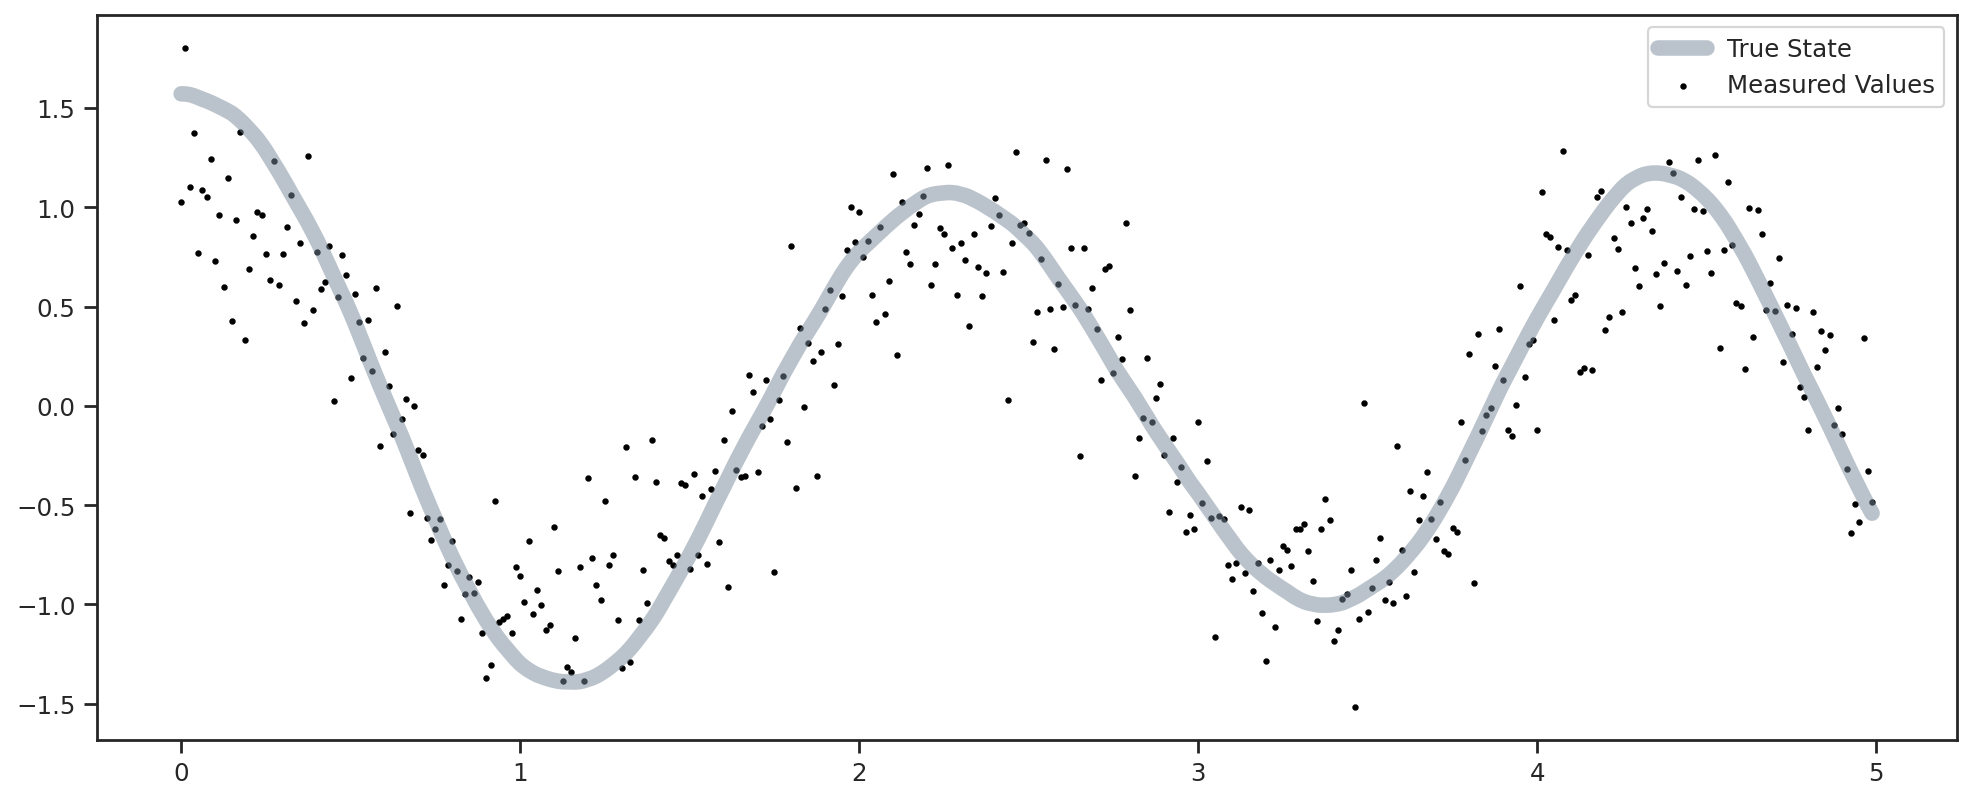

In [37]:
X = np.arange(0, 5, dt).reshape(-1, 1)

Q_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(Q)).sample(X.shape[0])

R_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(R)).sample(X.shape[0])

state_ = initial_state; state_I = initial_state
state = []; obs = []

for i in range(X.shape[0]):
  state_ = f(state_) + Q_samples[i, :, tf.newaxis]
  obs_ = h(state_) + R_samples[i, :, tf.newaxis]
  state.append(state_)
  obs.append(obs_)
  
state = np.array(state).reshape(-1, 2)
obs = np.array(obs).reshape(-1, 2)
print((obs).shape)

plt.figure(figsize=(15, 6))
plt.plot(X, state[:,0], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(X, obs[:, 0], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.legend(); plt.show()

100%|██████████| 400/400 [02:57<00:00,  2.25it/s]


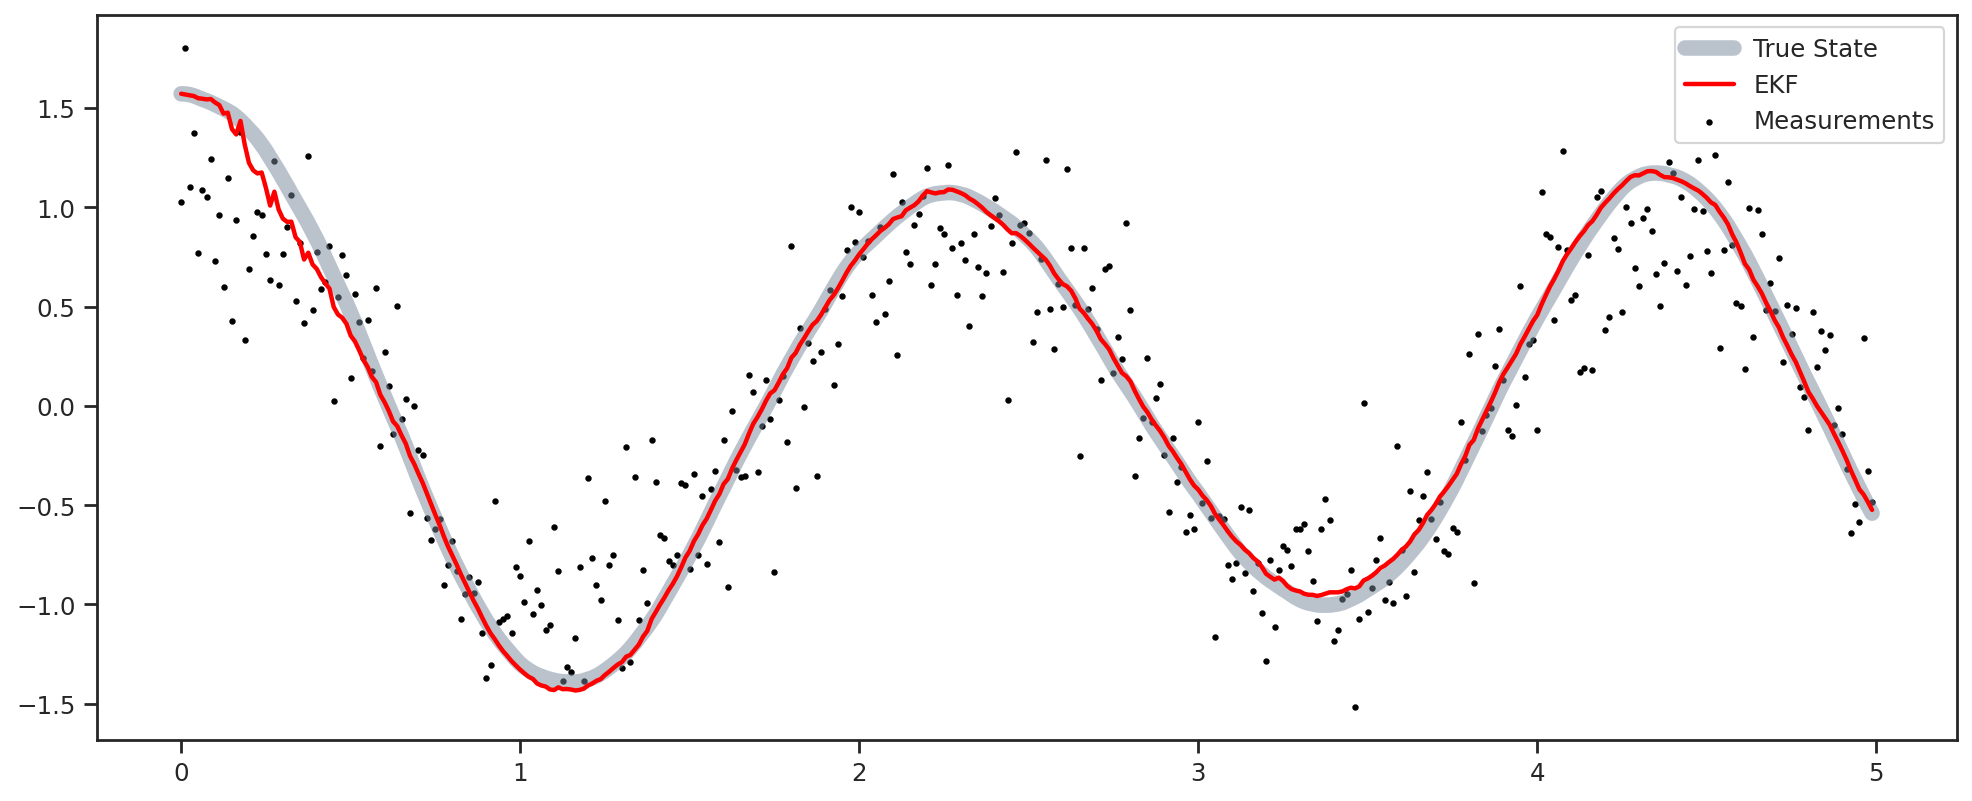

In [38]:
Σ_0 = tf.eye(2)*0.1
µ_EKF, Σ_EKF, _ = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, 1)

plt.figure(figsize=(15, 6))
plt.plot(X, state[:,0], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(X, obs[:, 0], color="black", s=3.5, alpha=1.0, label="Measurements")
plt.plot(X, µ_EKF[:,0], color="red", linewidth=2.0, alpha=1, label="EKF")
plt.legend(); plt.show()

100%|██████████| 400/400 [00:00<00:00, 744.63it/s]


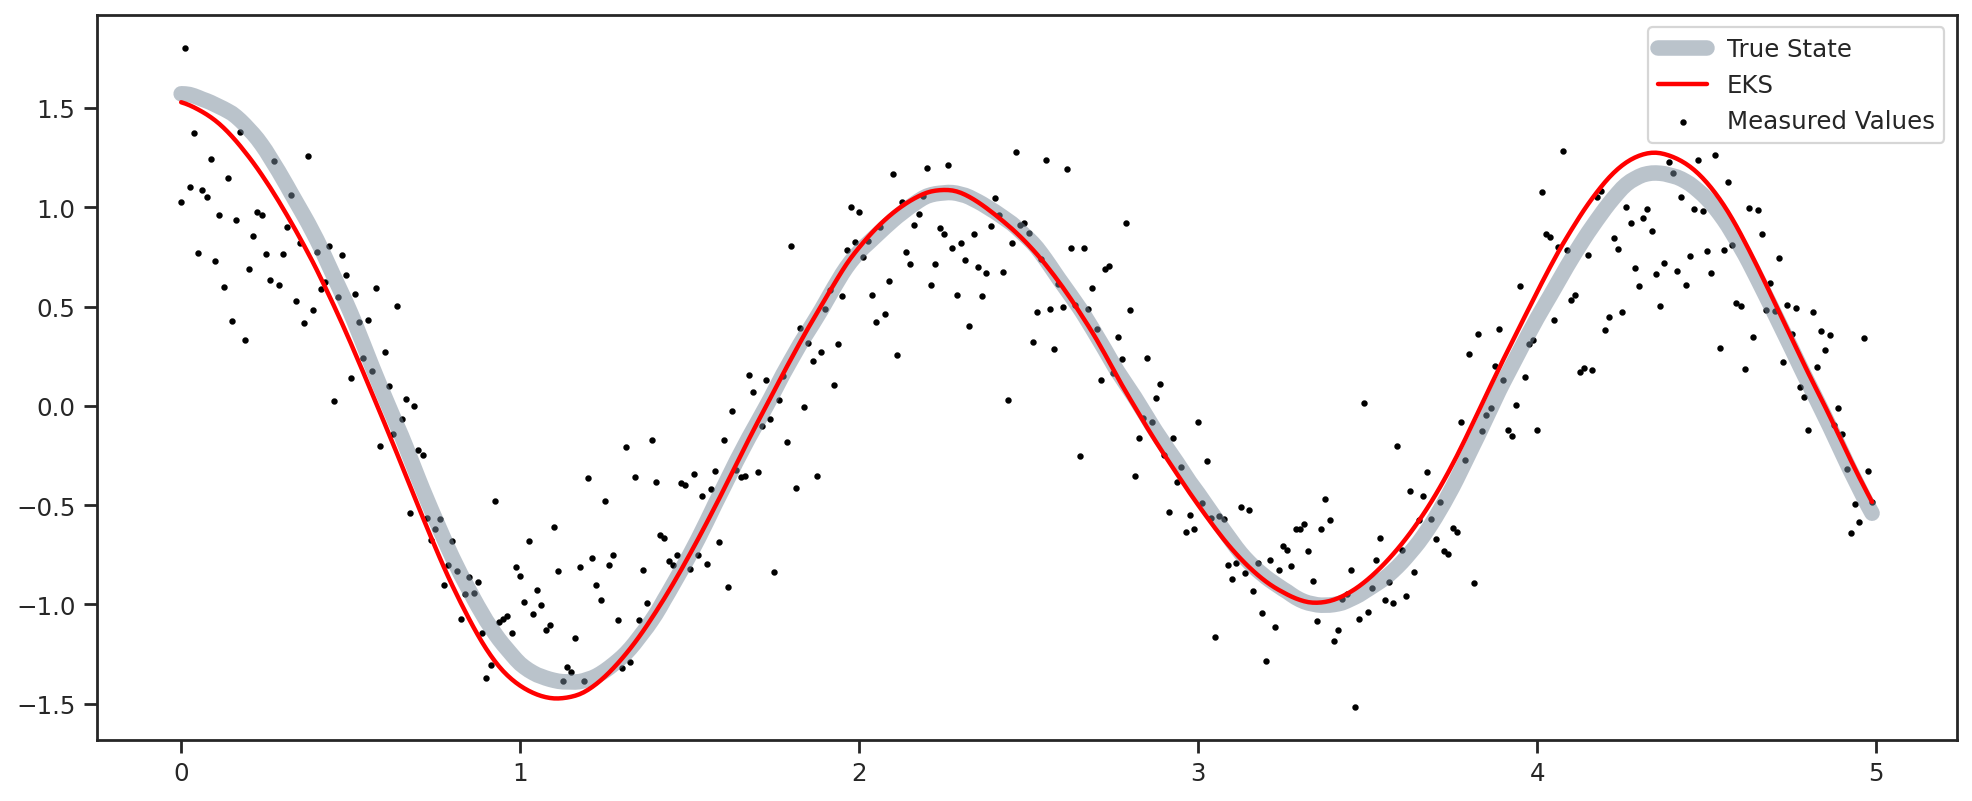

In [39]:
µ_EKS, Σ_EKS = LinearizedExtendedKalmanSmoother(f, Q, µ_EKF, Σ_EKF)

plt.figure(figsize=(15, 6))
plt.plot(X, state[:,0], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.plot(X, µ_EKS[:,0], color="red", linewidth=2.0, alpha=1, label="EKS")
plt.scatter(X, obs[:,0], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.legend(); plt.show()

## EKF on Tracking a Spiraling Object
### [Reference](https://colab.research.google.com/github/probml/dynamax/blob/main/docs/notebooks/nonlinear_gaussian_ssm/ekf_ukf_spiral.ipynb)

The state equations are

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
&=
  \begin{pmatrix} z_{1,t-1} + 0.4\cdot \sin(z_{2,t-1} )  \\
    z_{2,t-1} + 0.4\cdot \cos(z_{1,t-1} )
     \end{pmatrix}
+q_{t} \\ \\
  y_t
&=  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}\\ \\
q_t &\sim N(0,Q) \\
r_t &\sim N(0,R)\\ \\
Q &= c\cdot\mathbf I \\
R &= d\cdot\mathbf I
\end{align*}
for some constants $c, \ d$.

In [40]:
@tf.function
def f(x):
  return x + 0.4 * tf.stack([tf.sin(x[..., 1, :]), 
                             tf.cos(x[..., 0, :])], -2)

@tf.function
def h(x):
  return x

Q = tf.eye(2)*0.001
R = tf.eye(2)*0.05

initial_state = tf.constant([1.5, 0])[:, tf.newaxis]

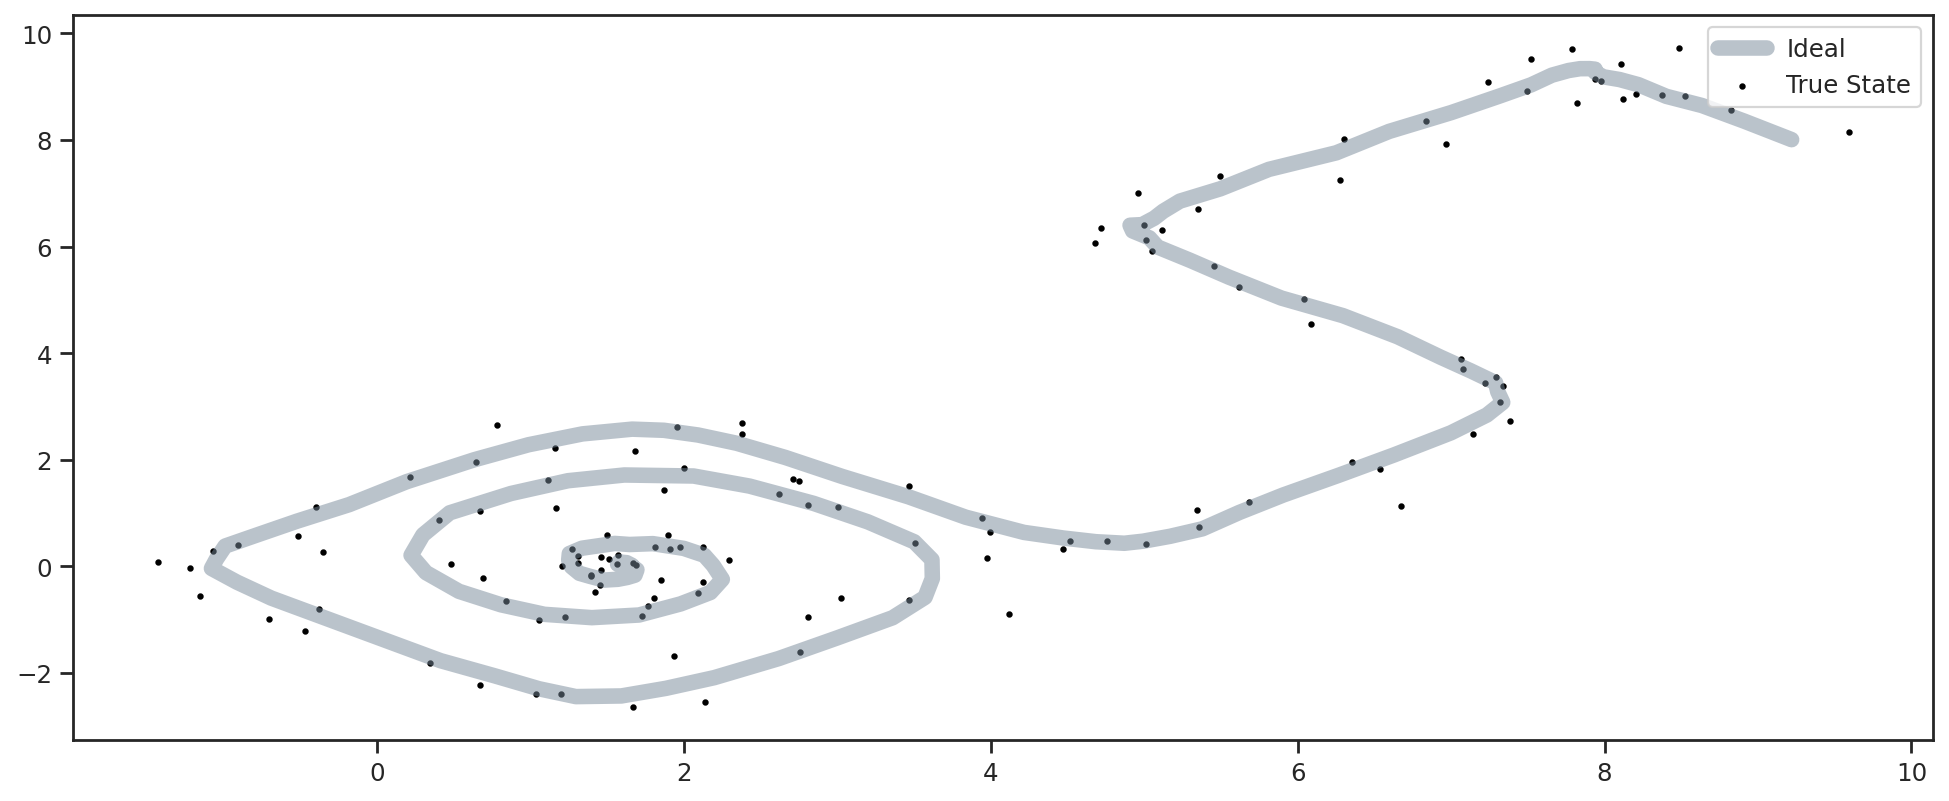

In [41]:
steps = 130

Q_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(Q)).sample(steps)

R_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(R)).sample(steps)

state_ = initial_state
state = []; obs = []

for i in range(steps):
  state_ = f(state_) + Q_samples[i, :, tf.newaxis]
  obs_ = h(state_) + R_samples[i, :, tf.newaxis]
  state.append(state_)
  obs.append(obs_)

state = np.array(state).reshape(-1, 2)
obs = np.array(obs).reshape(-1, 2)

plt.figure(figsize=(15, 6))
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="True State")
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="Ideal")
plt.legend(); plt.show()

100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


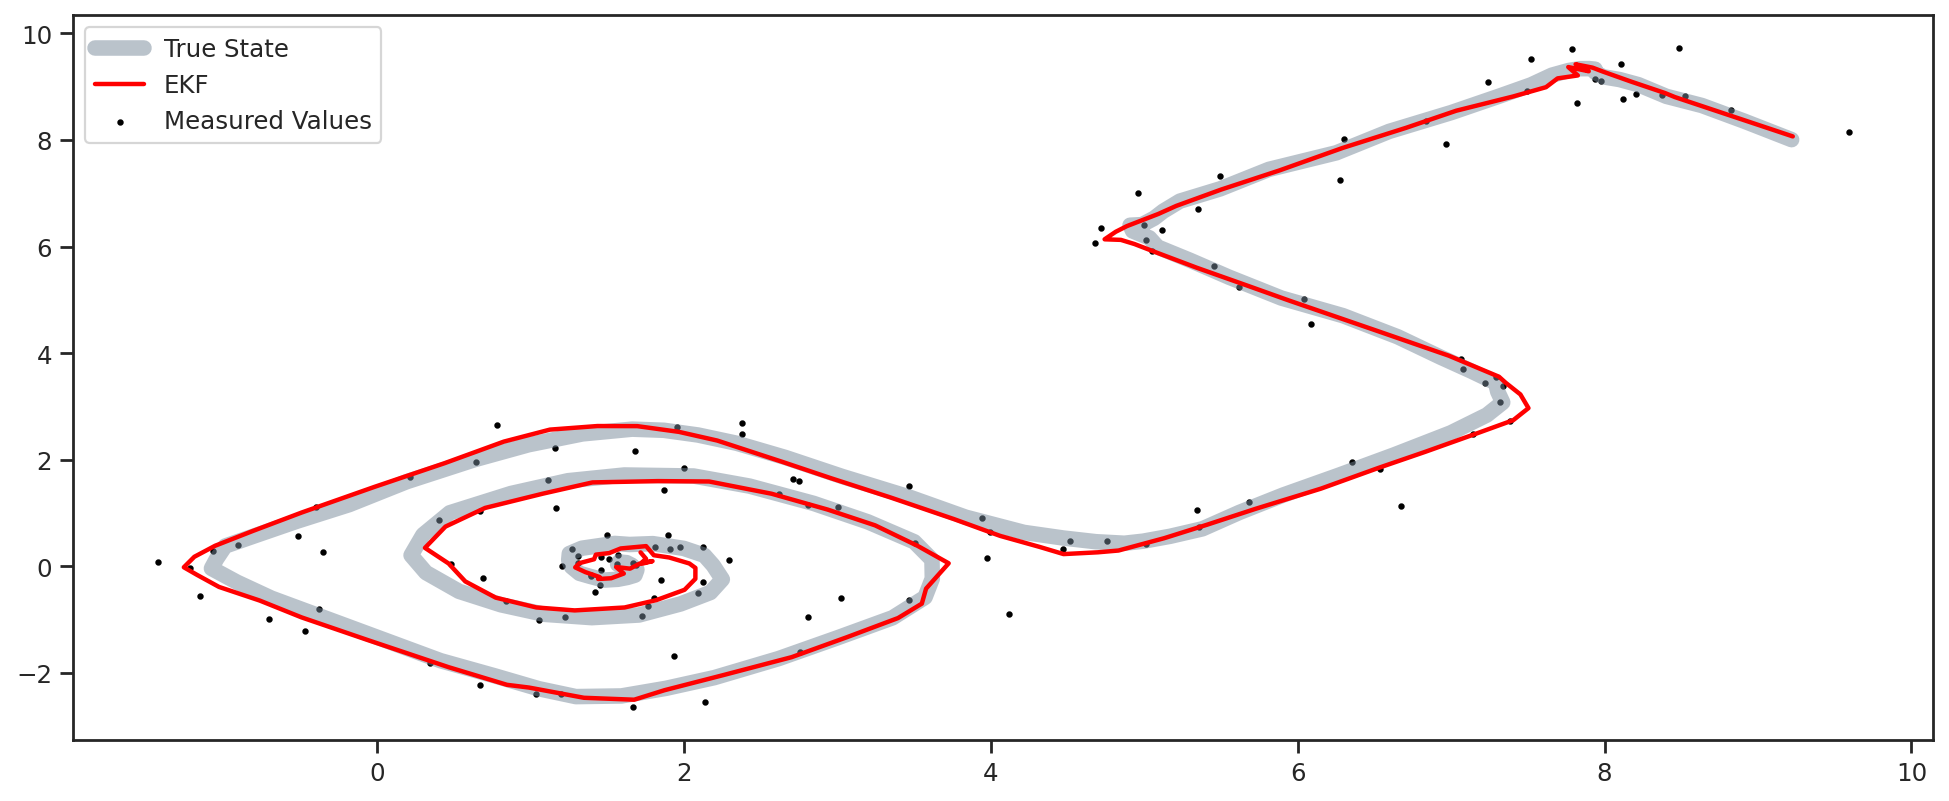

In [42]:
Σ_0 = tf.eye(2)*0.1
µ_EKF, Σ_EKF, l = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, 1)

plt.figure(figsize=(15, 6))
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.plot(µ_EKF[:,0], µ_EKF[:,1], color="red", linewidth=2.0, alpha=1, label="EKF")
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.legend(); plt.show()

100%|██████████| 130/130 [02:00<00:00,  1.07it/s]


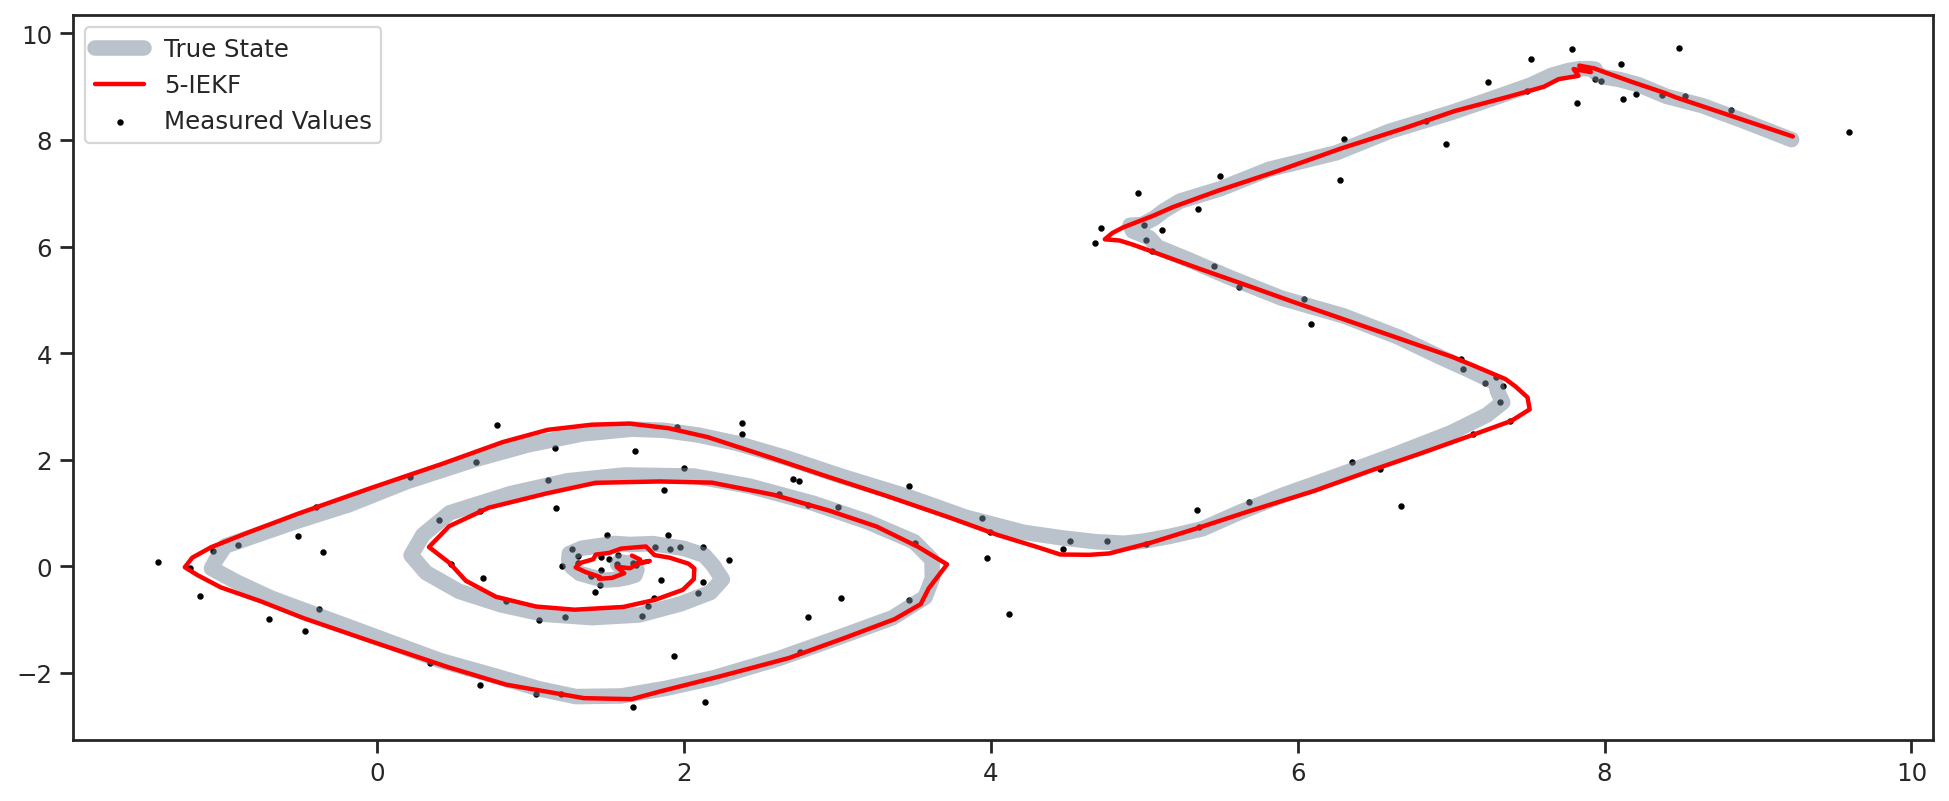

In [46]:
J = 5
µ_IEKF, Σ_IEKF, l = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, J)
µ_IEKF = np.array(µ_IEKF); Σ_IEKF = np.array(Σ_IEKF)

plt.figure(figsize=(15, 6))
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.plot(µ_IEKF[:,0], µ_IEKF[:,1], color="red", linewidth=2.0, alpha=1, label= str(J) + "-IEKF")
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.legend(); plt.show()